# COVID-19 
(Previously known as nCoV-2019)
<img src='https://ars.els-cdn.com/content/image/3-s2.0-B9780443073670000409-f040-001-9780443073670.jpg'>

<b>Overview:</b> <br>
Tracking the COVID-19 viral infections around the world.

<b>Data Source:</b> <br>
Johns Hopkins University Center for Systems Science and Engineering (JHU CCSE) <br>
https://github.com/CSSEGISandData/COVID-19 <br>
The Lancet <br>
https://www.thelancet.com/pb-assets/Lancet/pdfs/S0140673620302117.pdf <br>
Clinical outcome (99 Cases)
<li> Remained in hospital 57 (58%)
<li> Discharged 31 (31%)
<li> Died 11 (11%)
<br>
JAMA (The Journal of the American Medical Association)<br>    
https://jamanetwork.com/journals/jama/fullarticle/2761044 <br>
<li>In this single-center case series of 138 hospitalized patients with confirmed NCIP in Wuhan, China, presumed hospital-related transmission of 2019-nCoV was suspected in 41% of patients, 26% of patients received ICU care, and mortality was 4.3%.

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jan 28 08:19:13 2020
"""
import datetime as dt
import warnings
warnings.filterwarnings("ignore")
#import packages
import smtx_ncov as sm
import pandas as pd
import numpy as np
import xlrd
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import pandas_datareader as pdr
from tabulate import tabulate
from matplotlib import style
from matplotlib.pylab import rcParams
style.use('fivethirtyeight')
# style.use('ggplot')

In [2]:
c_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
f_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
r_url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'

In [3]:
c_csv=pd.read_csv(c_url)
f_csv=pd.read_csv(f_url)
r_csv=pd.read_csv(r_url)

In [4]:
def covid_clean(df):
    c_csv=df
    
    c_csv["Province/State"]=c_csv["Province/State"].fillna('-')
    c_csv["Country"]=c_csv["Province/State"]+" "+c_csv["Country/Region"]
    c_csv.drop(['Province/State','Country/Region', 'Lat', 'Long'], axis=1, inplace=True)
    c_csv=c_csv.T
    recs = len(c_csv)-1
    c_csv.columns = c_csv.iloc[recs]
    c_csv=c_csv.drop(c_csv.index[recs])
    return c_csv

In [5]:
c_df=covid_clean(c_csv)
f_df=covid_clean(f_csv)
r_df=covid_clean(r_csv)

In [6]:
# Texas
tx = [x for x in c_df.columns if x.endswith('TX US')]
tx.sort()
c_df_tx = c_df[tx]
r_df_tx = r_df[tx]
f_df_tx = f_df[tx]
# US
us = [x for x in c_df.columns if x.endswith('US')]
us.sort()
c_df_us = c_df[us]
r_df_us = r_df[us]
f_df_us = f_df[us]
# China
ch = [x for x in c_df.columns if x.endswith('China')]
ch.sort()
c_df_ch = c_df[ch]
r_df_ch = r_df[ch]
f_df_ch = f_df[ch]
# Canada
ca = [x for x in c_df.columns if x.endswith('Canada')]
ca.sort()
c_df_ca = c_df[ca]
r_df_ca = r_df[ca]
f_df_ca = f_df[ca]


In [7]:
# Diamond Princess
location='Diamond'
c_df_dp = c_df.filter(regex=location)
r_df_dp = r_df.filter(regex=location)
f_df_dp = f_df.filter(regex=location)


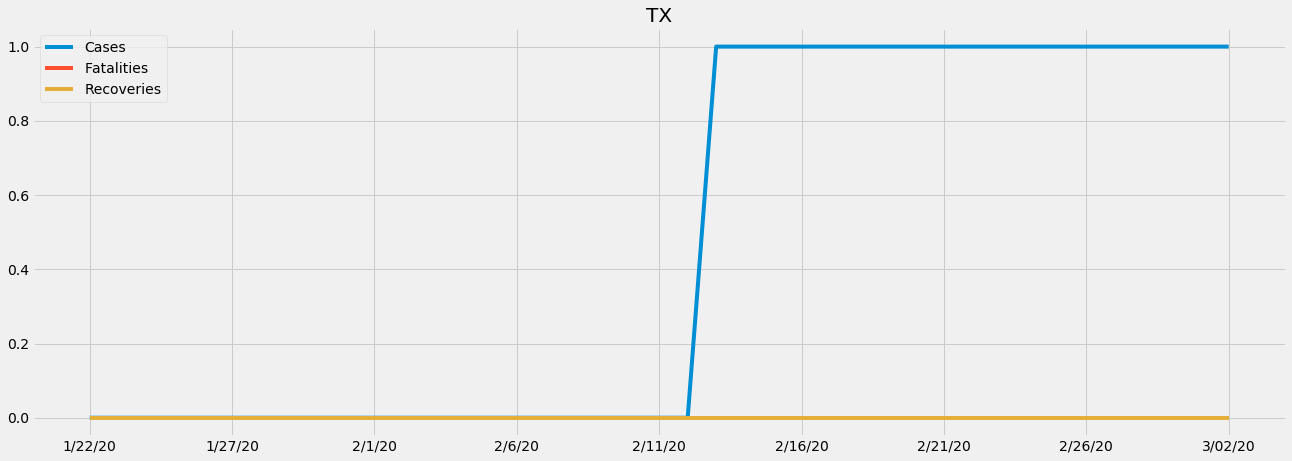

TX locations:
 |-- San Antonio



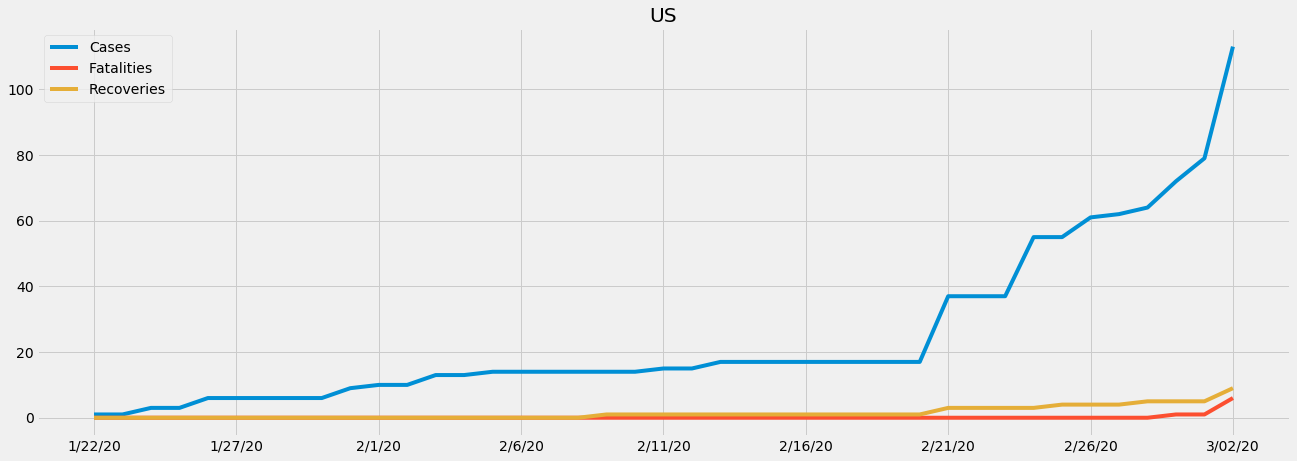

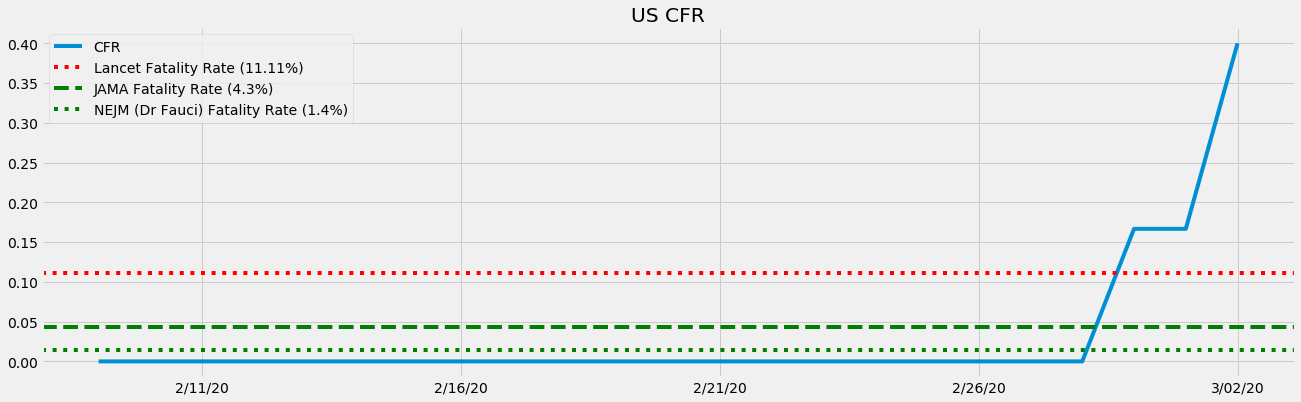

US locations:
 |-- Boston, MA
 |-- Cook County, IL
 |-- Cook County, IL
 |-- Grafton County, NH
 |-- Hillsborough, FL
 |-- Humboldt County, CA
 |-- King County, WA
 |-- Lackland, TX (From Diamond Princess)
 |-- Los Angeles, CA
 |-- Madison, WI
 |-- New York City, NY
 |-- Omaha, NE (From Diamond Princess)
 |-- Orange, CA
 |-- Placer County, CA
 |-- Portland, OR
 |-- Providence, RI
 |-- Sacramento County, CA
 |-- San Antonio, TX
 |-- San Benito, CA
 |-- San Diego County, CA
 |-- San Mateo, CA
 |-- Santa Clara, CA
 |-- Sarasota, FL
 |-- Snohomish County, WA
 |-- Sonoma County, CA
 |-- Tempe, AZ
 |-- Travis, CA (From Diamond Princess)
 |-- Umatilla, OR
 |-- Unassigned Location (From Diamond Princess)


In [8]:
rcParams['figure.figsize'] = 20,7
c_df_tx.sum(axis=1).plot(title='TX', label='Cases')
f_df_tx.sum(axis=1).plot(label='Fatalities')
r_df_tx.sum(axis=1).plot(label='Recoveries')
plt.legend()
plt.show()
print('TX locations:')
for lo in tx:
    print(' |--',lo[:-7])
print()
c_df_us.sum(axis=1).plot(title='US', label='Cases')
f_df_us.sum(axis=1).plot(label='Fatalities')
r_df_us.sum(axis=1).plot(label='Recoveries')
plt.legend()
plt.show()
#US CFR
f= pd.DataFrame(f_df_us.sum(axis=1))
r= pd.DataFrame(r_df_us.sum(axis=1))
f_n_r = (f+r)
f_n_r
cfr = f/f_n_r.replace({ 0 : np.nan })
cfr.columns=['CFR']
rcParams['figure.figsize'] = 20,6
cfr.plot(label='US CFR', title='US CFR')
plt.axhline(y=11/99, color='red', linestyle=':', label = 'Lancet Fatality Rate (11.11%)')
plt.axhline(y=4.3/100, color='green', linestyle='--', label = 'JAMA Fatality Rate (4.3%)')
plt.axhline(y=1.4/100, color='green', linestyle=':', label = 'NEJM (Dr Fauci) Fatality Rate (1.4%)')
plt.legend()
plt.show()
print('US locations:')
for lo in us:
    print(' |--',lo[:-3])

Global
------
Cases:       90,313
Recoveries:  45,602
Fatalities:   3,085
Remaining:   41,626
In ICU:       4,579


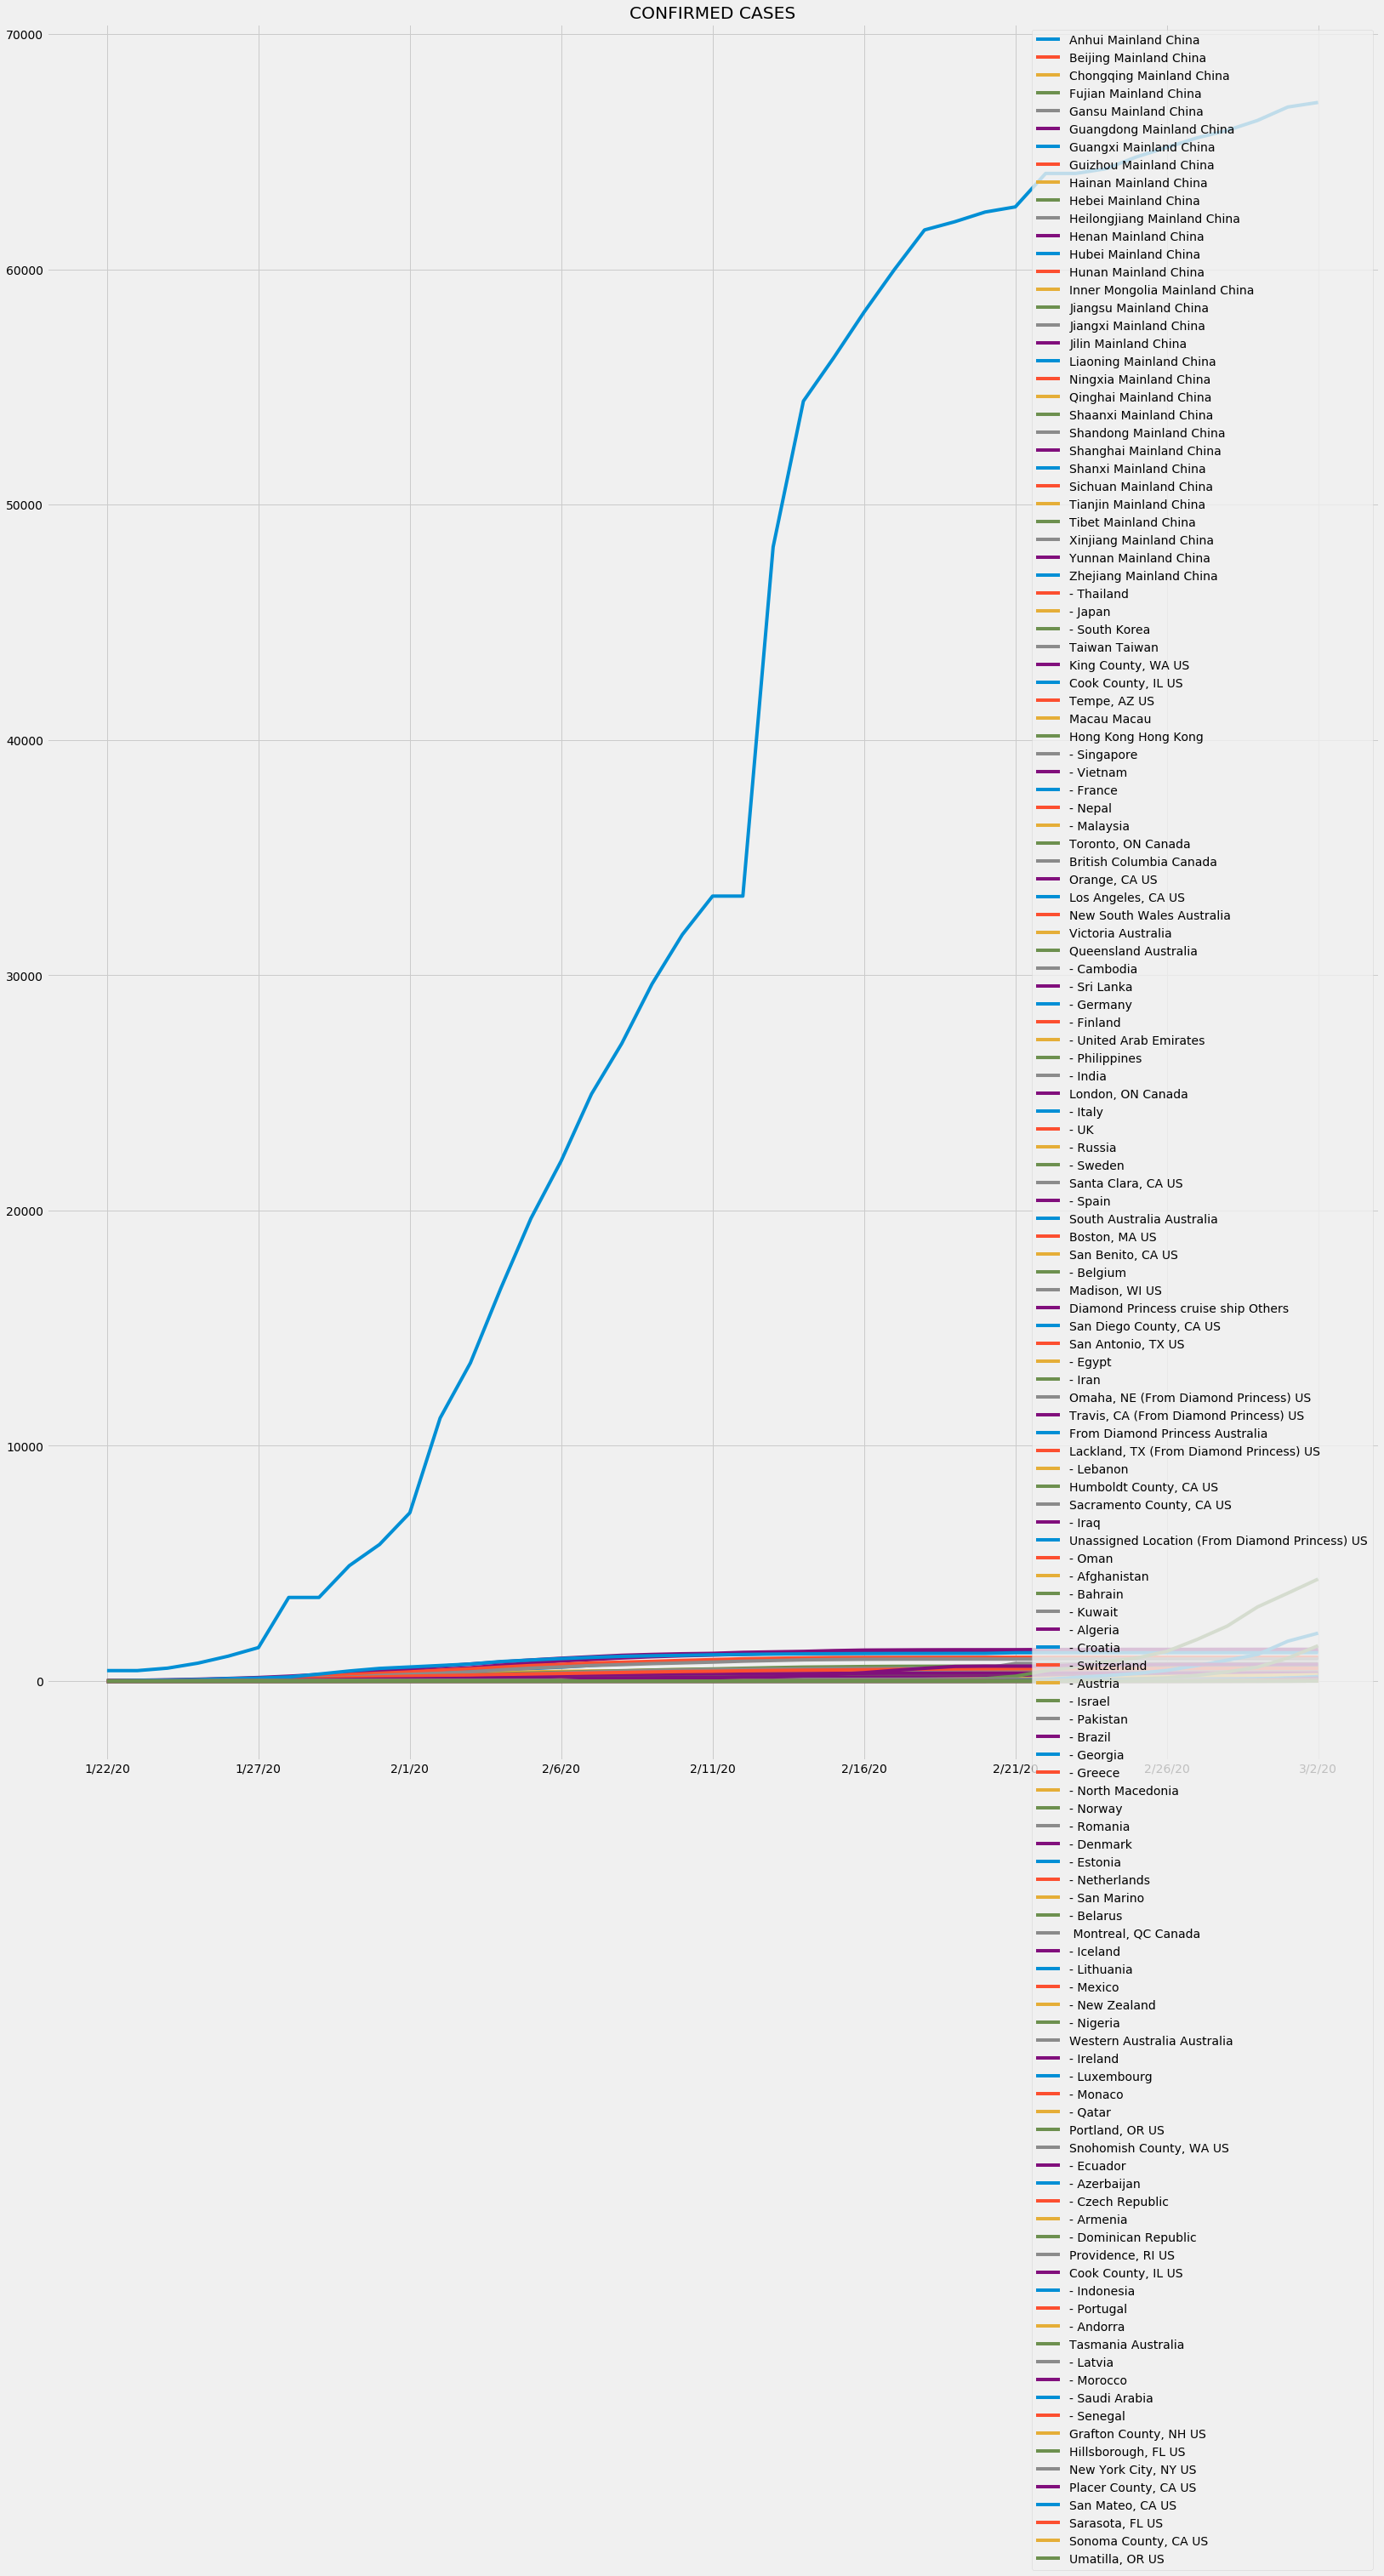

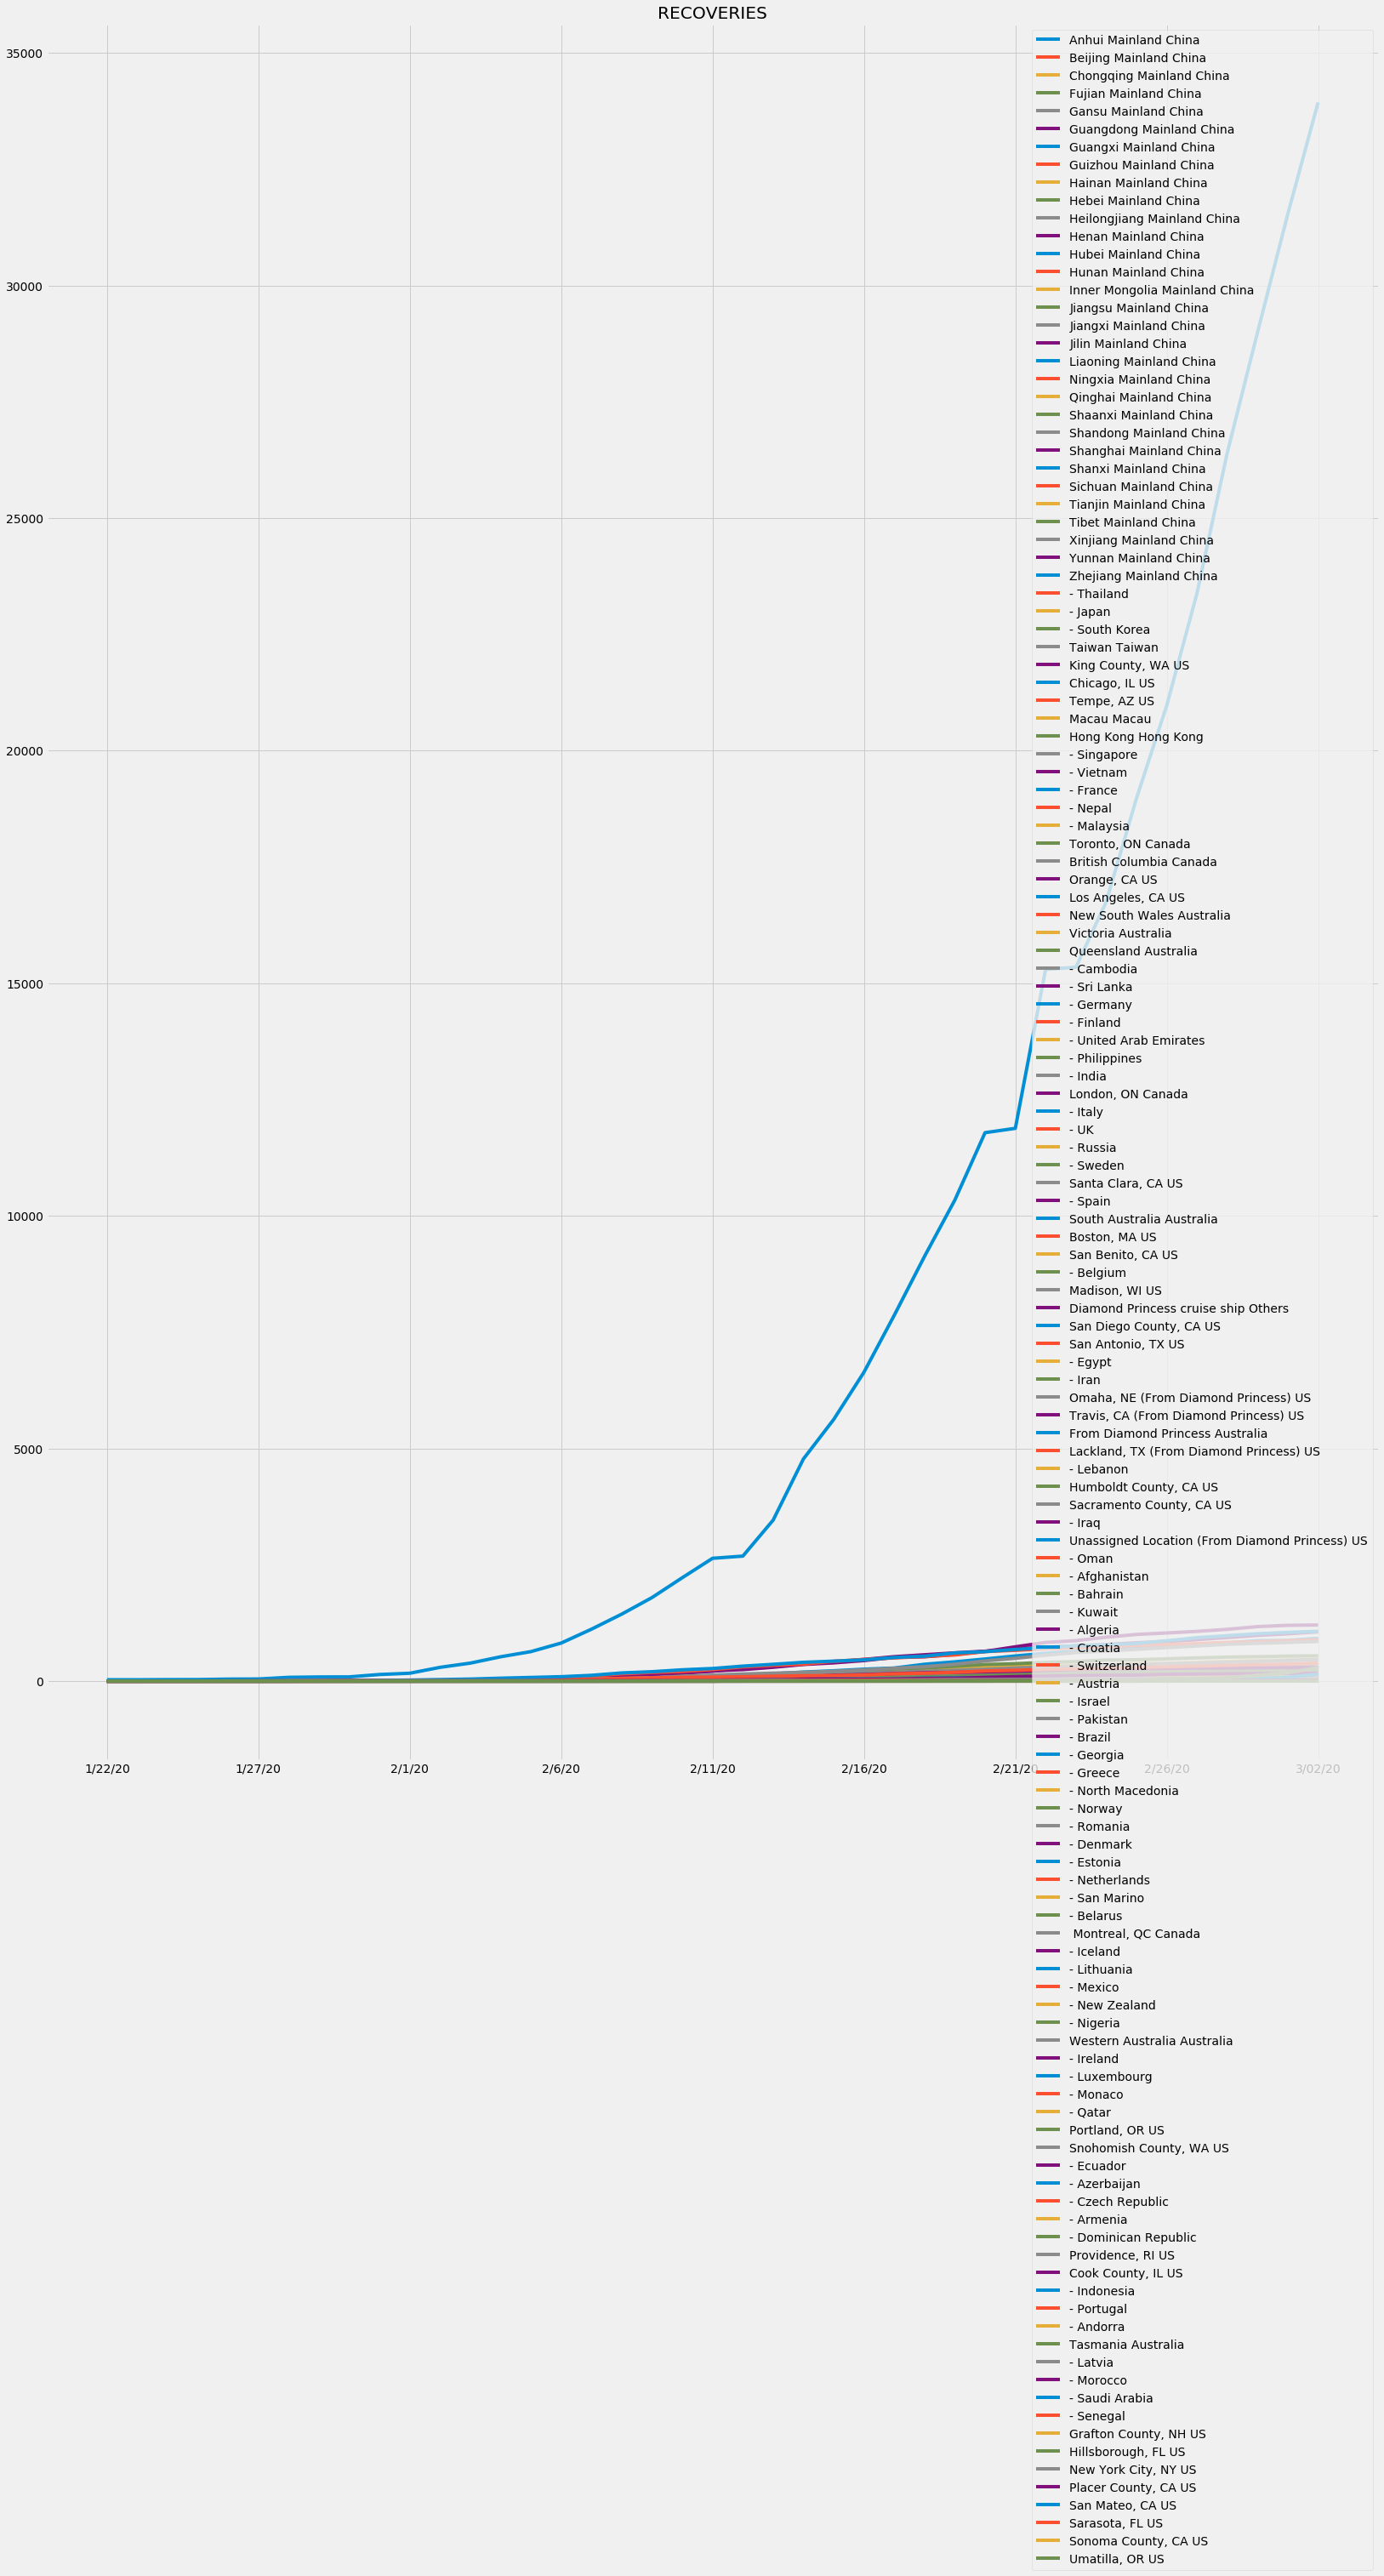

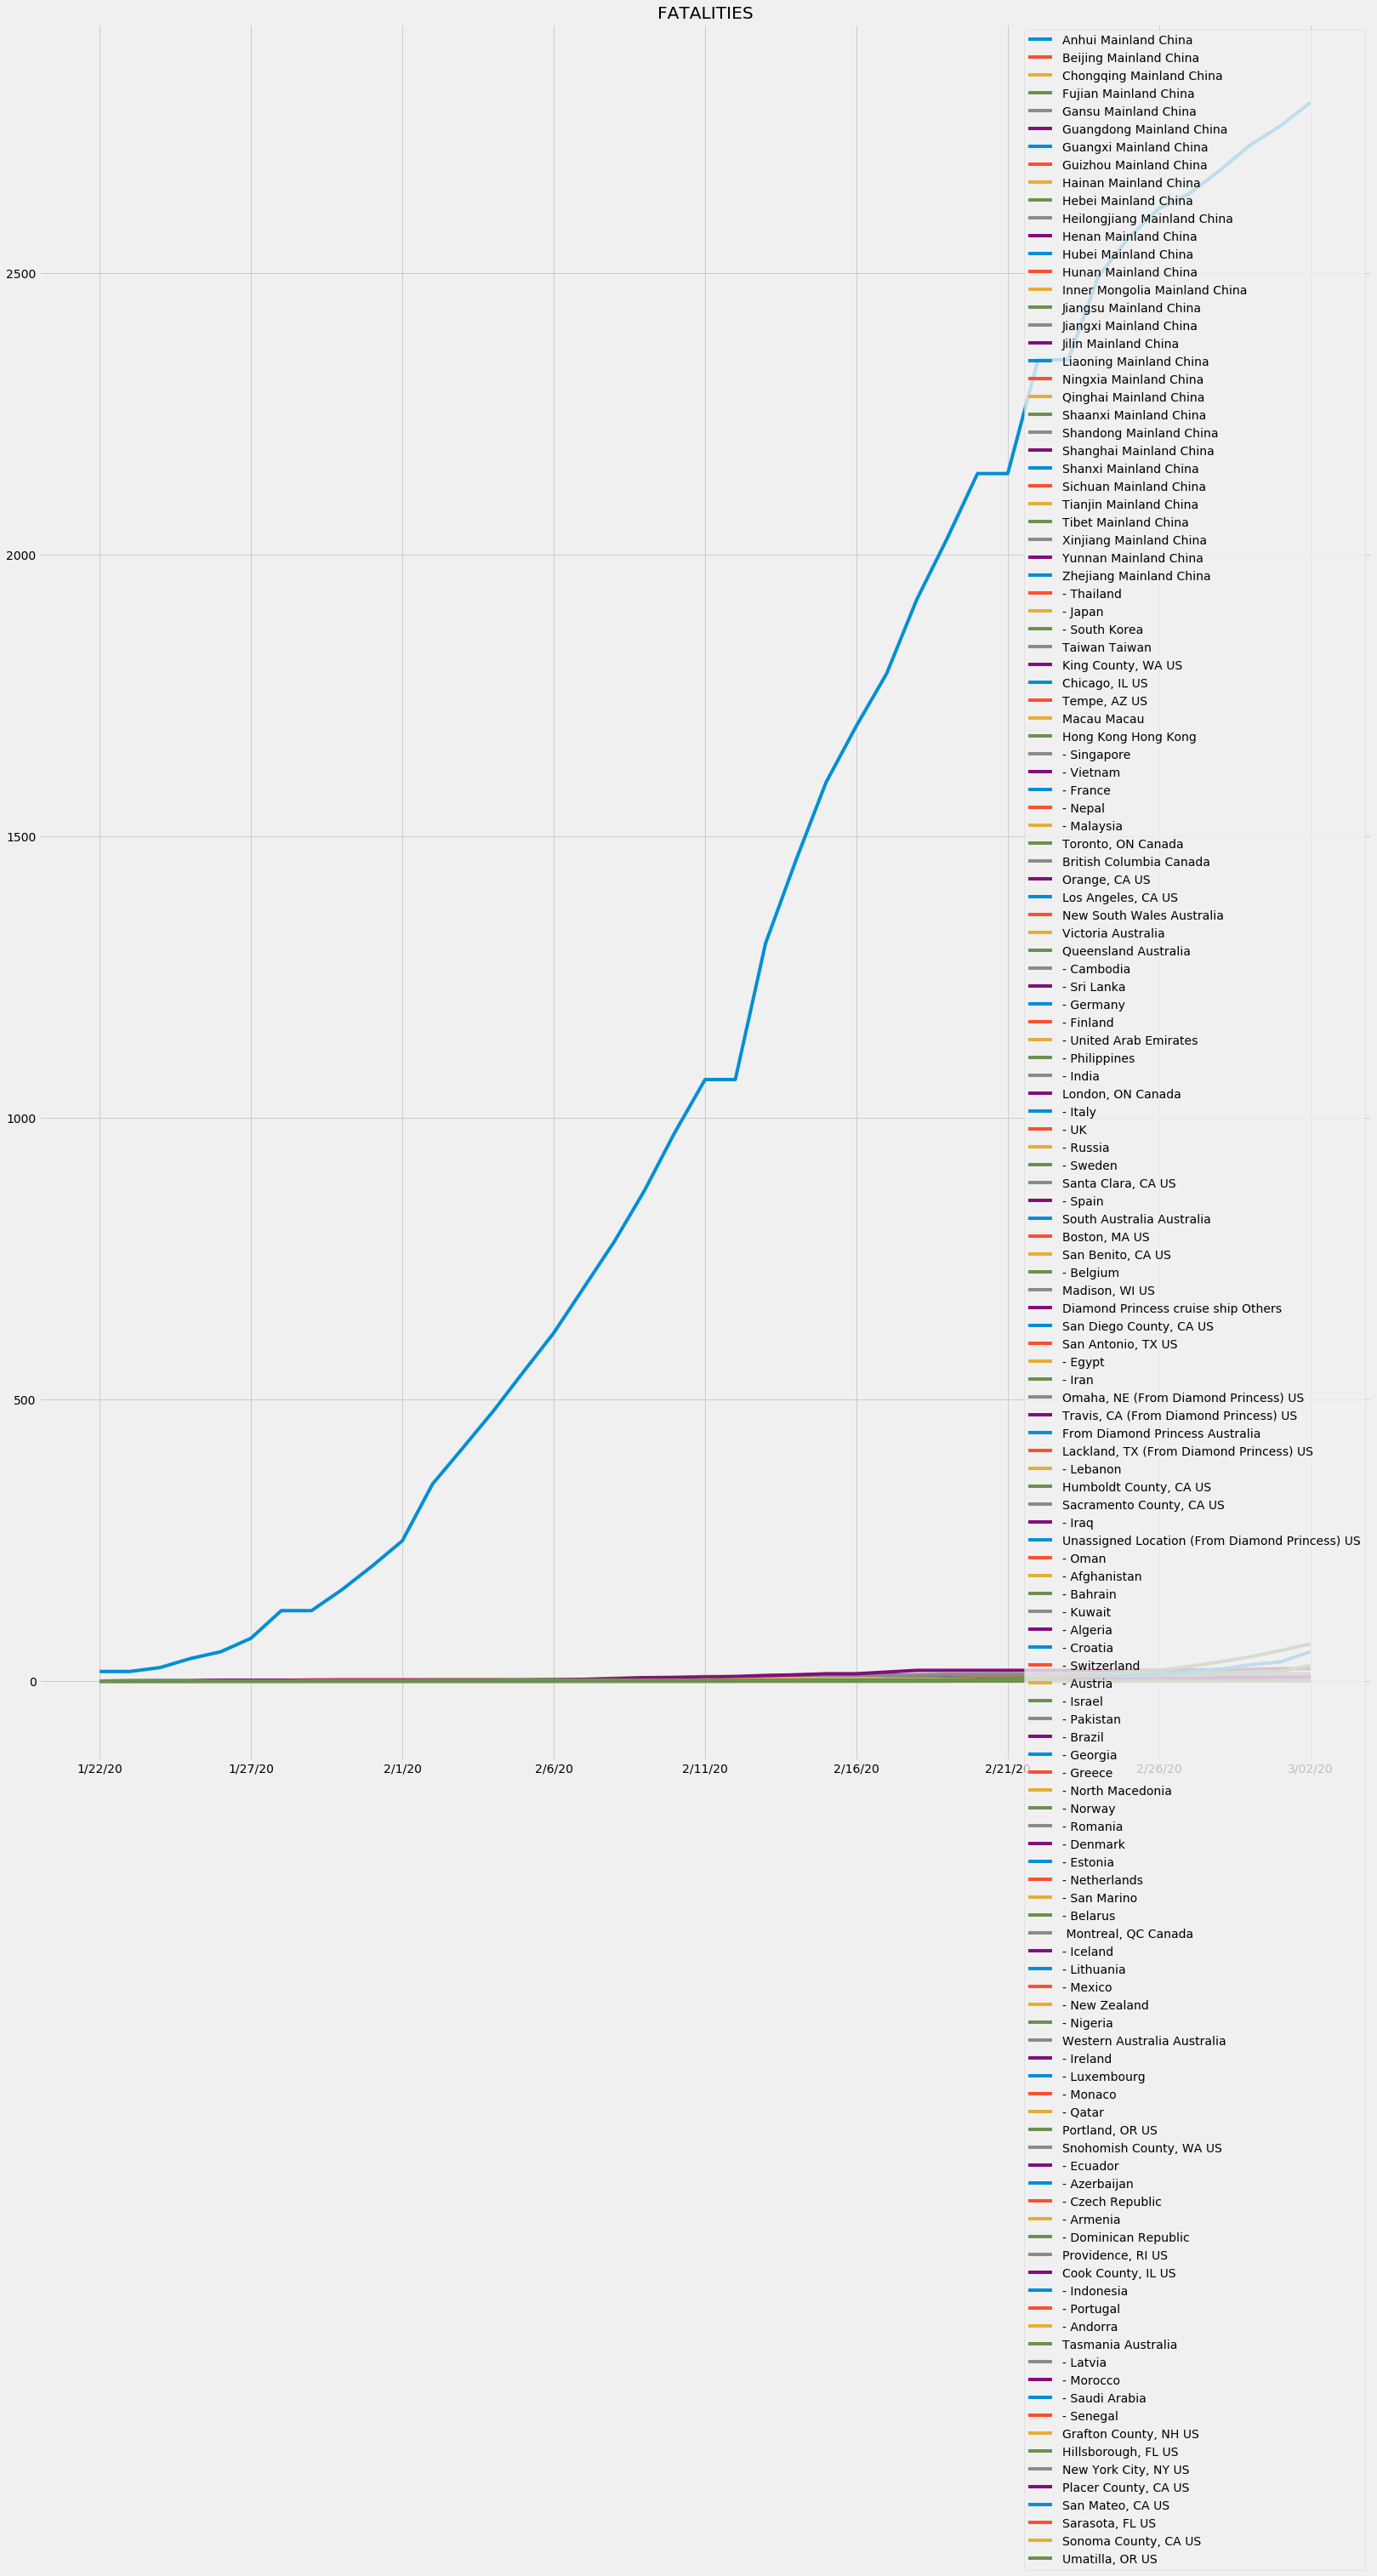

In [9]:
cg = (c_df.tail(1).sum(axis=1))[0]
rg = (r_df.tail(1).sum(axis=1))[0]
fg = (f_df.tail(1).sum(axis=1))[0]

print('Global')
print('------')
print('Cases:       {:,.0f}'.format(cg))
print('Recoveries:  {:,.0f}'.format(rg))
print('Fatalities:   {:,.0f}'.format(fg))
print('Remaining:   {:,.0f}'.format(cg-rg-fg))
print('In ICU:       {:,.0f}'.format((cg-rg-fg)*.11))

rcParams['figure.figsize'] = 25,35
# c_csv.plot(xticks=c_csv.index)
c_df.plot(title='CONFIRMED CASES', grid=True)
plt.legend()
plt.show()

r_df.plot(title='RECOVERIES')
plt.legend()
plt.show()

f_df.plot(title='FATALITIES')
plt.legend()
plt.show()

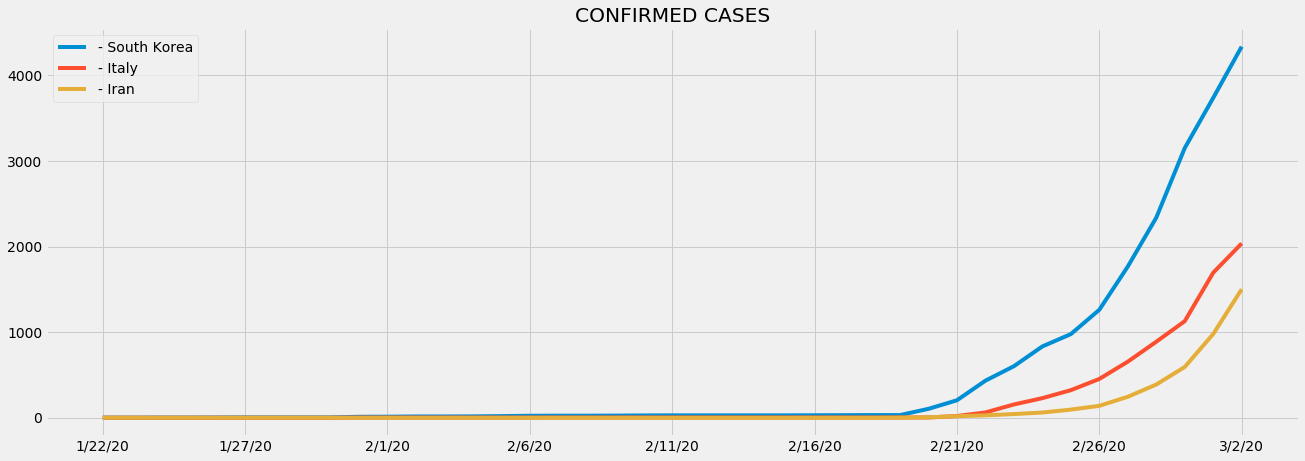

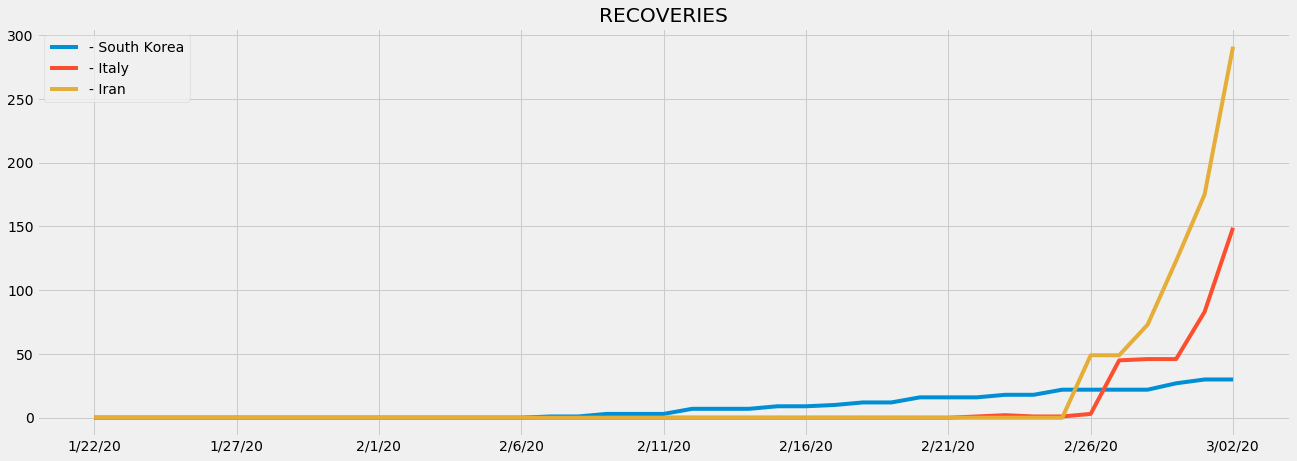

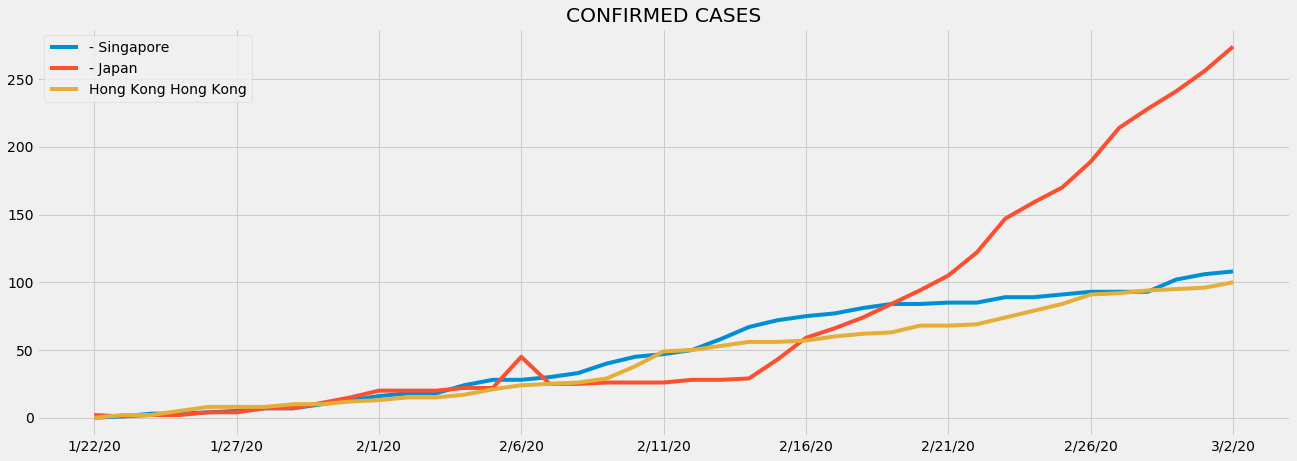

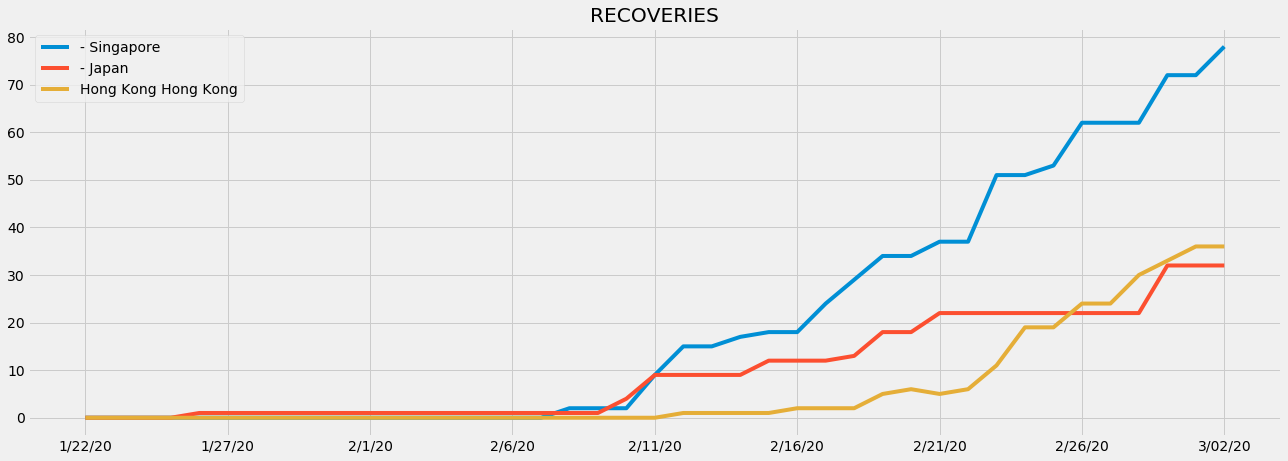

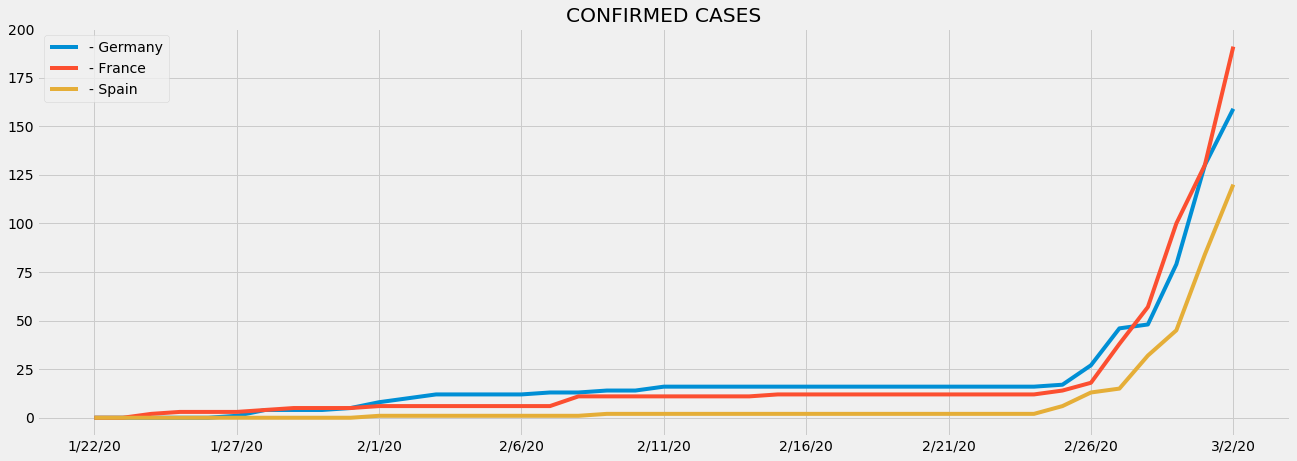

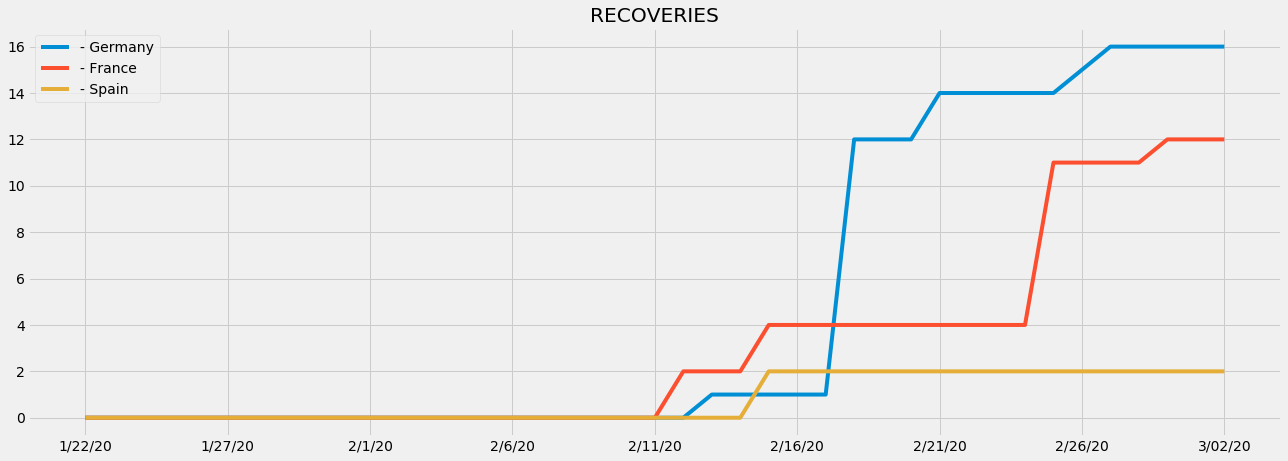

In [10]:
# Slices
a=f_df.iloc[:,0:31]
b=r_df.iloc[:,0:31]
c=f_df.iloc[:,31:]
d=r_df.iloc[:,31:]

rcParams['figure.figsize'] = 20,7
# c_csv.plot(xticks=c_csv.index)

c_df['- South Korea'].plot(title='CONFIRMED CASES')
c_df['- Italy'].plot()
c_df['- Iran'].plot()
plt.legend()
plt.show()

r_df['- South Korea'].plot(title='RECOVERIES')
r_df['- Italy'].plot()
r_df['- Iran'].plot()
plt.legend()
plt.show()


c_df['- Singapore'].plot(title='CONFIRMED CASES')
c_df['- Japan'].plot()
c_df['Hong Kong Hong Kong'].plot()
plt.legend()
plt.show()

r_df['- Singapore'].plot(title='RECOVERIES')
r_df['- Japan'].plot()
r_df['Hong Kong Hong Kong'].plot()
plt.legend()
plt.show()

c_df['- Germany'].plot(title='CONFIRMED CASES')
c_df['- France'].plot()
c_df['- Spain'].plot()
plt.legend()
plt.show()

r_df['- Germany'].plot(title='RECOVERIES')
r_df['- France'].plot()
r_df['- Spain'].plot()
plt.legend()
plt.show()

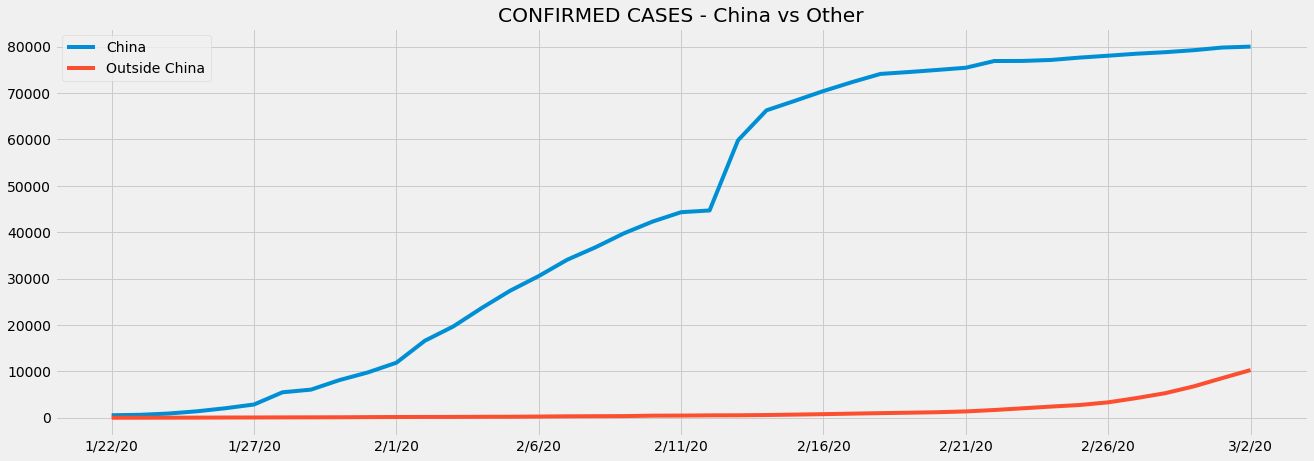

In [11]:
rcParams['figure.figsize'] = 20,7
c_df_ch.sum(axis=1).plot(label='China', title='CONFIRMED CASES - China vs Other')
c_df.iloc[:,31:].sum(axis=1).plot(label='Outside China')
plt.legend()
plt.show()

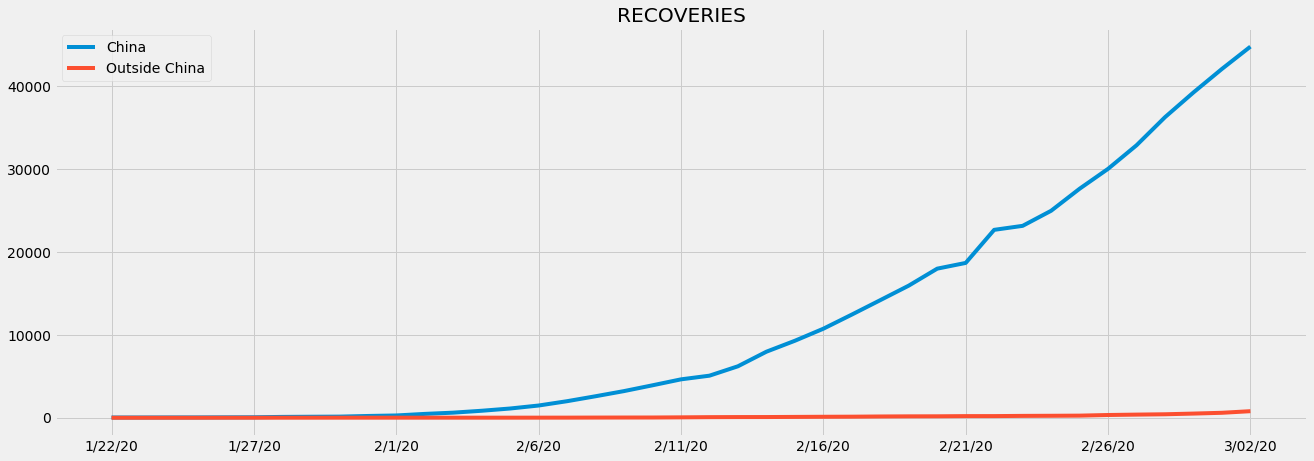

In [12]:
r_df_ch.sum(axis=1).plot(label='China', title='RECOVERIES')
r_df.iloc[:,31:].sum(axis=1).plot(label='Outside China')
plt.legend()
plt.show()

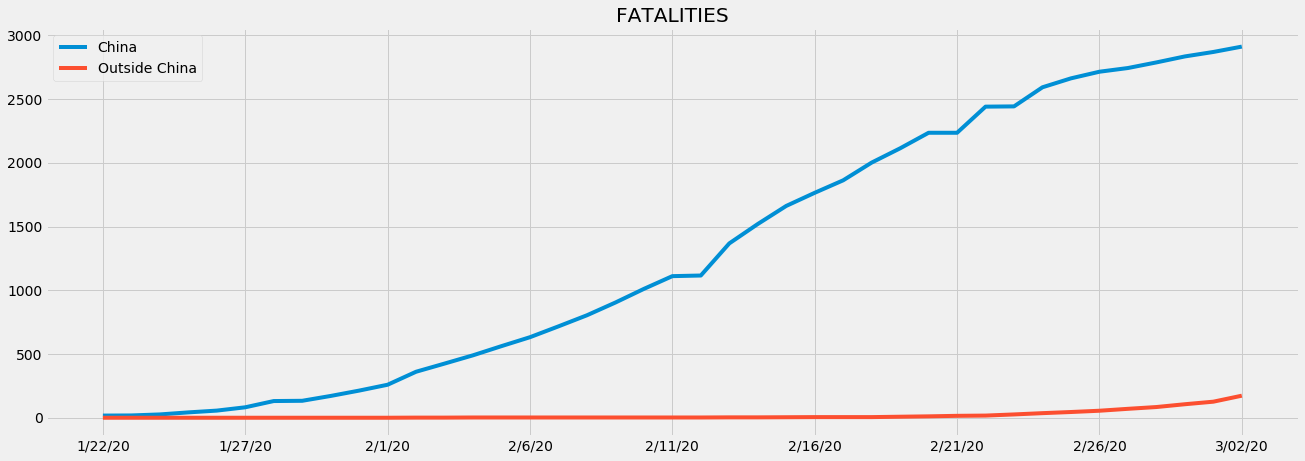

In [13]:
f_df_ch.sum(axis=1).plot(label='China', title='FATALITIES')
f_df.iloc[:,31:].sum(axis=1).plot(label='Outside China')
plt.legend()
plt.show()

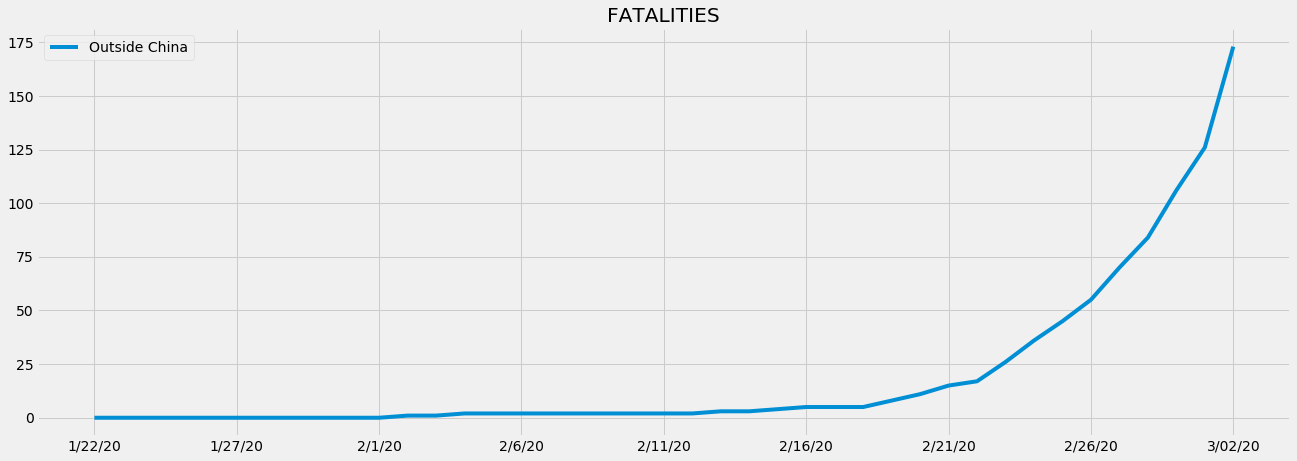

In [14]:
rcParams['figure.figsize'] = 20,7
c.sum(axis=1).plot(label='Outside China', title='FATALITIES')
n=len(c)
sma = c.rolling(7, min_periods=7, center=False, win_type=None, on=None, axis=0, closed=None).mean()
plt.legend()
plt.show()
csum=c.sum(axis=1)

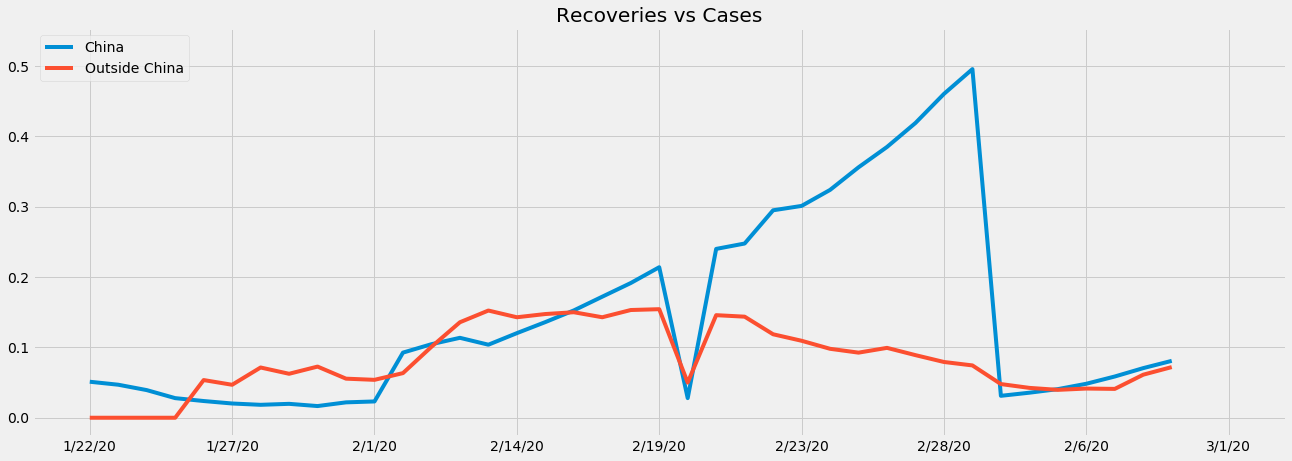

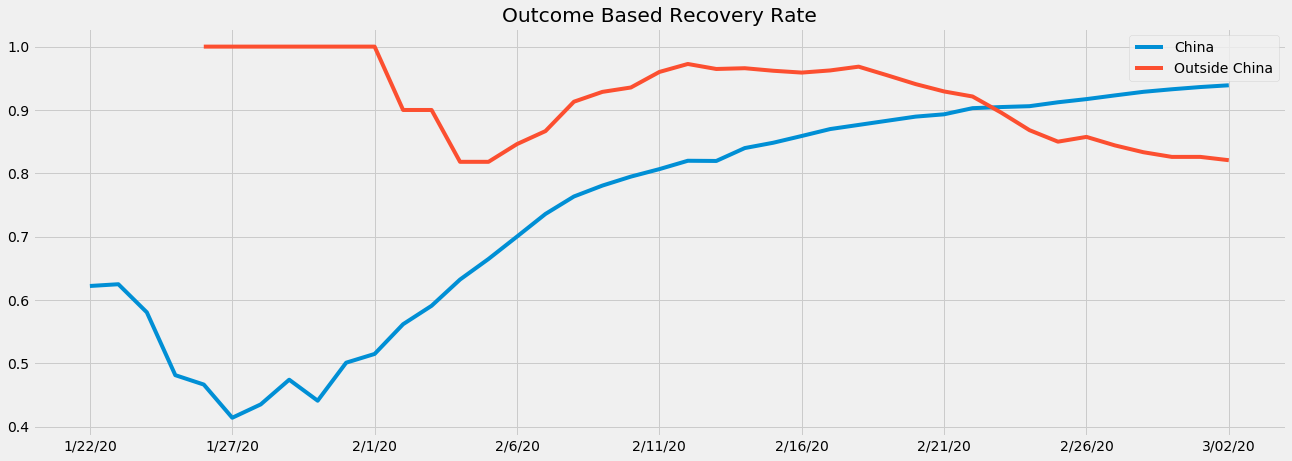

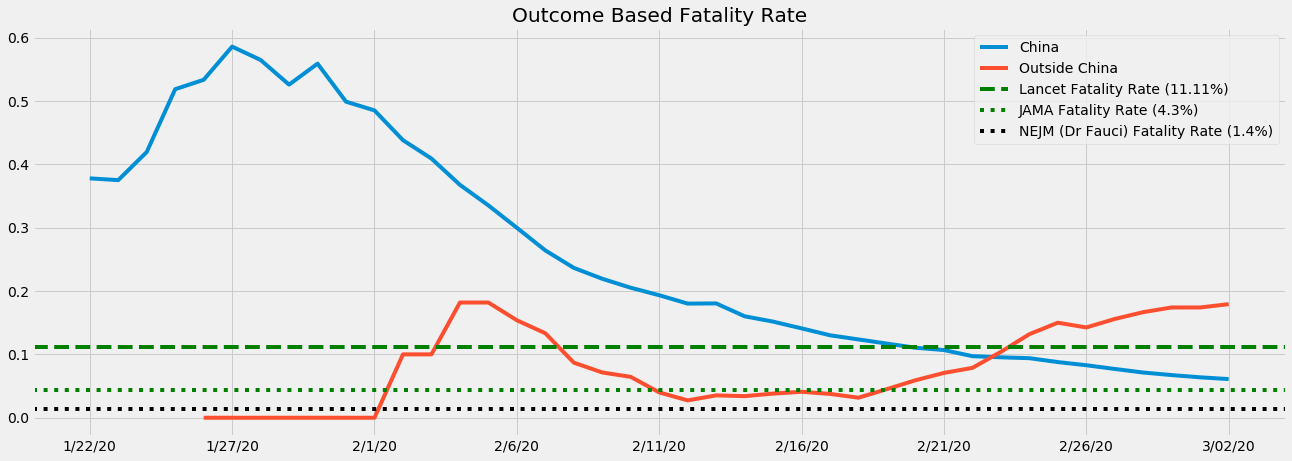

In [15]:


# f_df = f_df.set_index(pd.to_datetime(f_df.index))
((r_df.iloc[:,0:31].sum(axis=1))/
 (((c_df.iloc[:,0:31]).sum(axis=1)))).plot(label='China', title='Recoveries vs Cases')
((r_df.iloc[:,31:].sum(axis=1))/
 (((c_df.iloc[:,31:]).sum(axis=1)))).plot(label='Outside China')
plt.legend()
plt.show()

((r_df.iloc[:,0:31].sum(axis=1))/
 (((f_df.iloc[:,0:31]).sum(axis=1))+((r_df.iloc[:,0:31]).sum(axis=1)))).plot(label='China', title='Outcome Based Recovery Rate')
((r_df.iloc[:,31:].sum(axis=1))/
 (((f_df.iloc[:,31:]).sum(axis=1))+((r_df.iloc[:,31:]).sum(axis=1)))).plot(label='Outside China')
plt.legend()
plt.show()

((f_df.iloc[:,0:31].sum(axis=1))/
 (((f_df.iloc[:,0:31]).sum(axis=1))+((r_df.iloc[:,0:31]).sum(axis=1)))).plot(label='China', title='Outcome Based Fatality Rate')
((f_df.iloc[:,31:].sum(axis=1))/
 (((f_df.iloc[:,31:]).sum(axis=1))+((r_df.iloc[:,31:]).sum(axis=1)))).plot(label='Outside China')

# plt.axhline(y=0.5, color='black', linestyle=':', label = 'mr = 50%')
plt.axhline(y=11/99, color='green', linestyle='--', label = 'Lancet Fatality Rate (11.11%)')
plt.axhline(y=4.3/100, color='green', linestyle=':', label = 'JAMA Fatality Rate (4.3%)')
plt.axhline(y=1.4/100, color='black', linestyle=':', label = 'NEJM (Dr Fauci) Fatality Rate (1.4%)')

plt.legend()
plt.show()

In [16]:
#CFR
f= pd.DataFrame(f_df)
r= pd.DataFrame(r_df)
f_n_r = (f+r)
f_n_r
cfr = f/f_n_r.replace({ 0 : np.nan })

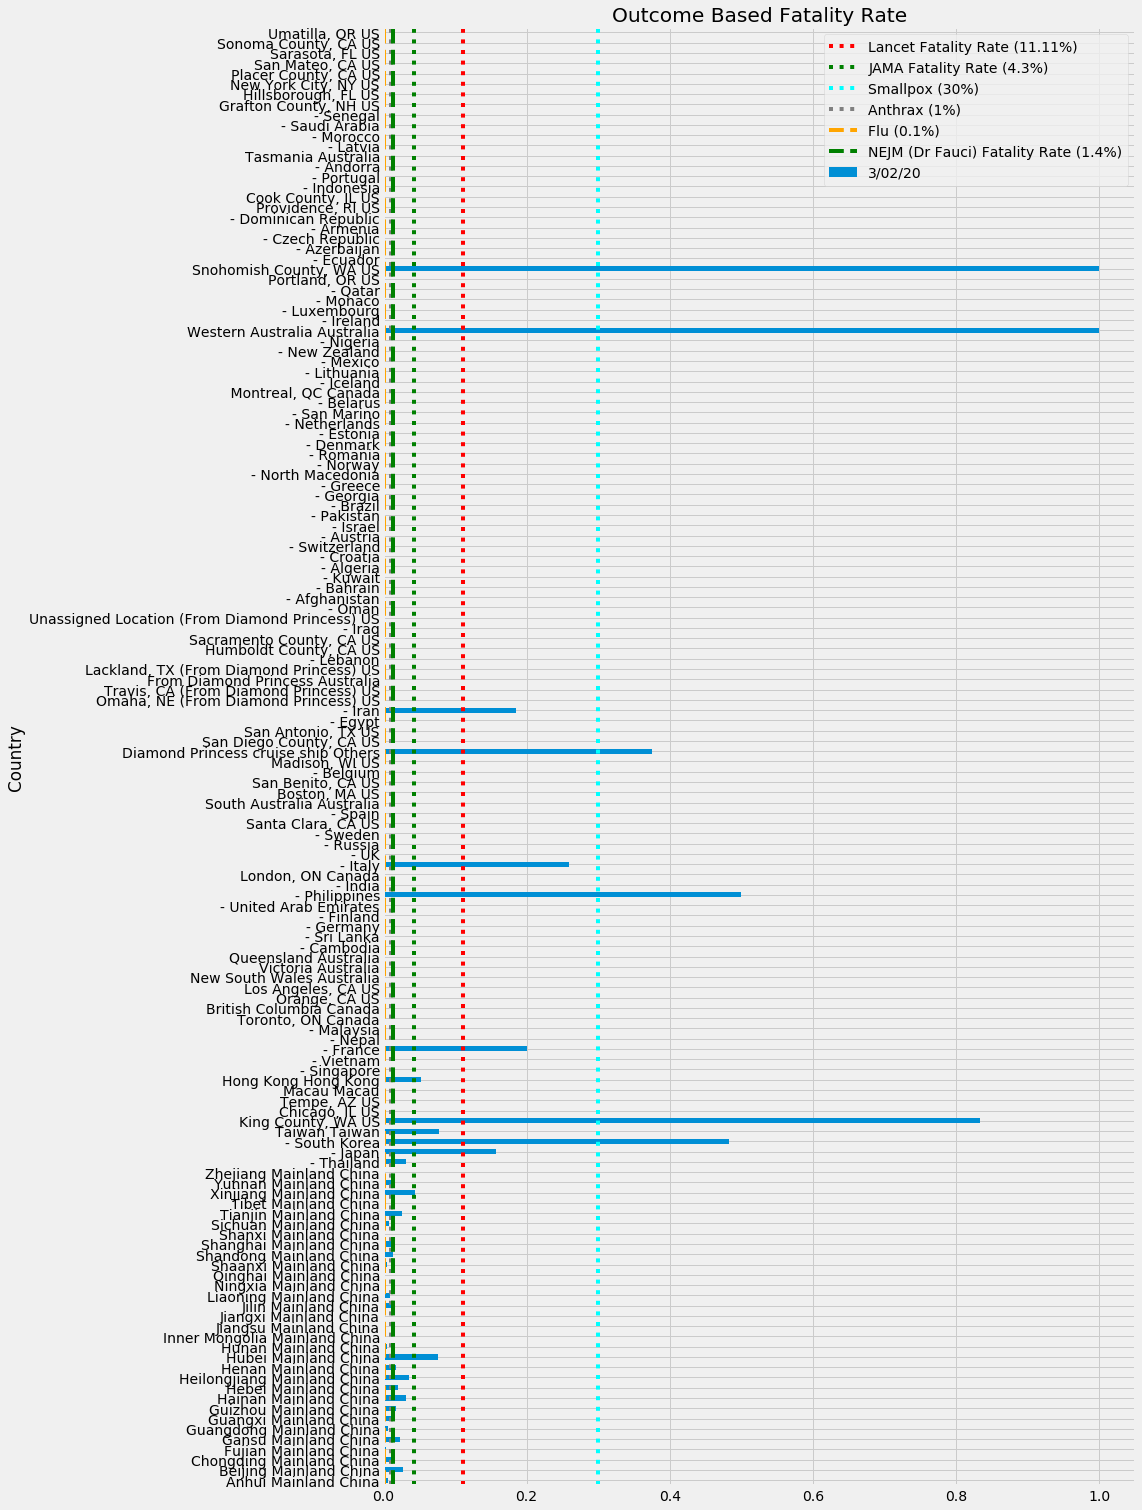

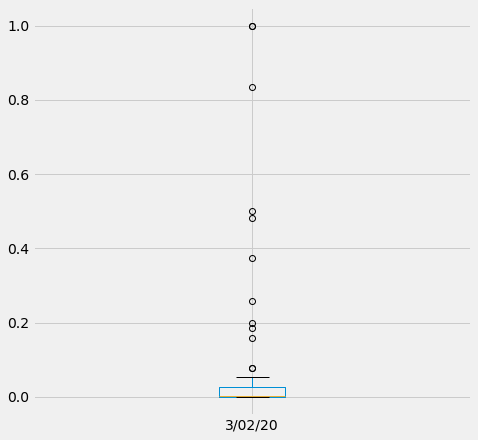

In [17]:
rcParams['figure.figsize'] = 12,25
cfrt = cfr.tail(1).T
cfrtval=cfrt[cfrt.columns[0]]
cfrtval.plot.barh(title='Outcome Based Fatality Rate')
# plt.axvline(x=0.5, color='black', linestyle=':', label = 'mr = 50%')
plt.axvline(x=11/99, color='red', linestyle=':', label = 'Lancet Fatality Rate (11.11%)')
plt.axvline(x=4.3/100, color='green', linestyle=':', label = 'JAMA Fatality Rate (4.3%)')
plt.axvline(x=.3, color='cyan', linestyle=':', label = 'Smallpox (30%)')
plt.axvline(x=.01, color='grey', linestyle=':', label = 'Anthrax (1%)')
plt.axvline(x=.001, color='orange', linestyle='--', label = 'Flu (0.1%)')
plt.axvline(x=1.4/100, color='green', linestyle='--', label = 'NEJM (Dr Fauci) Fatality Rate (1.4%)')
plt.legend()
plt.show()
rcParams['figure.figsize'] = 7,7
cfrtval.plot.box()
plt.show()

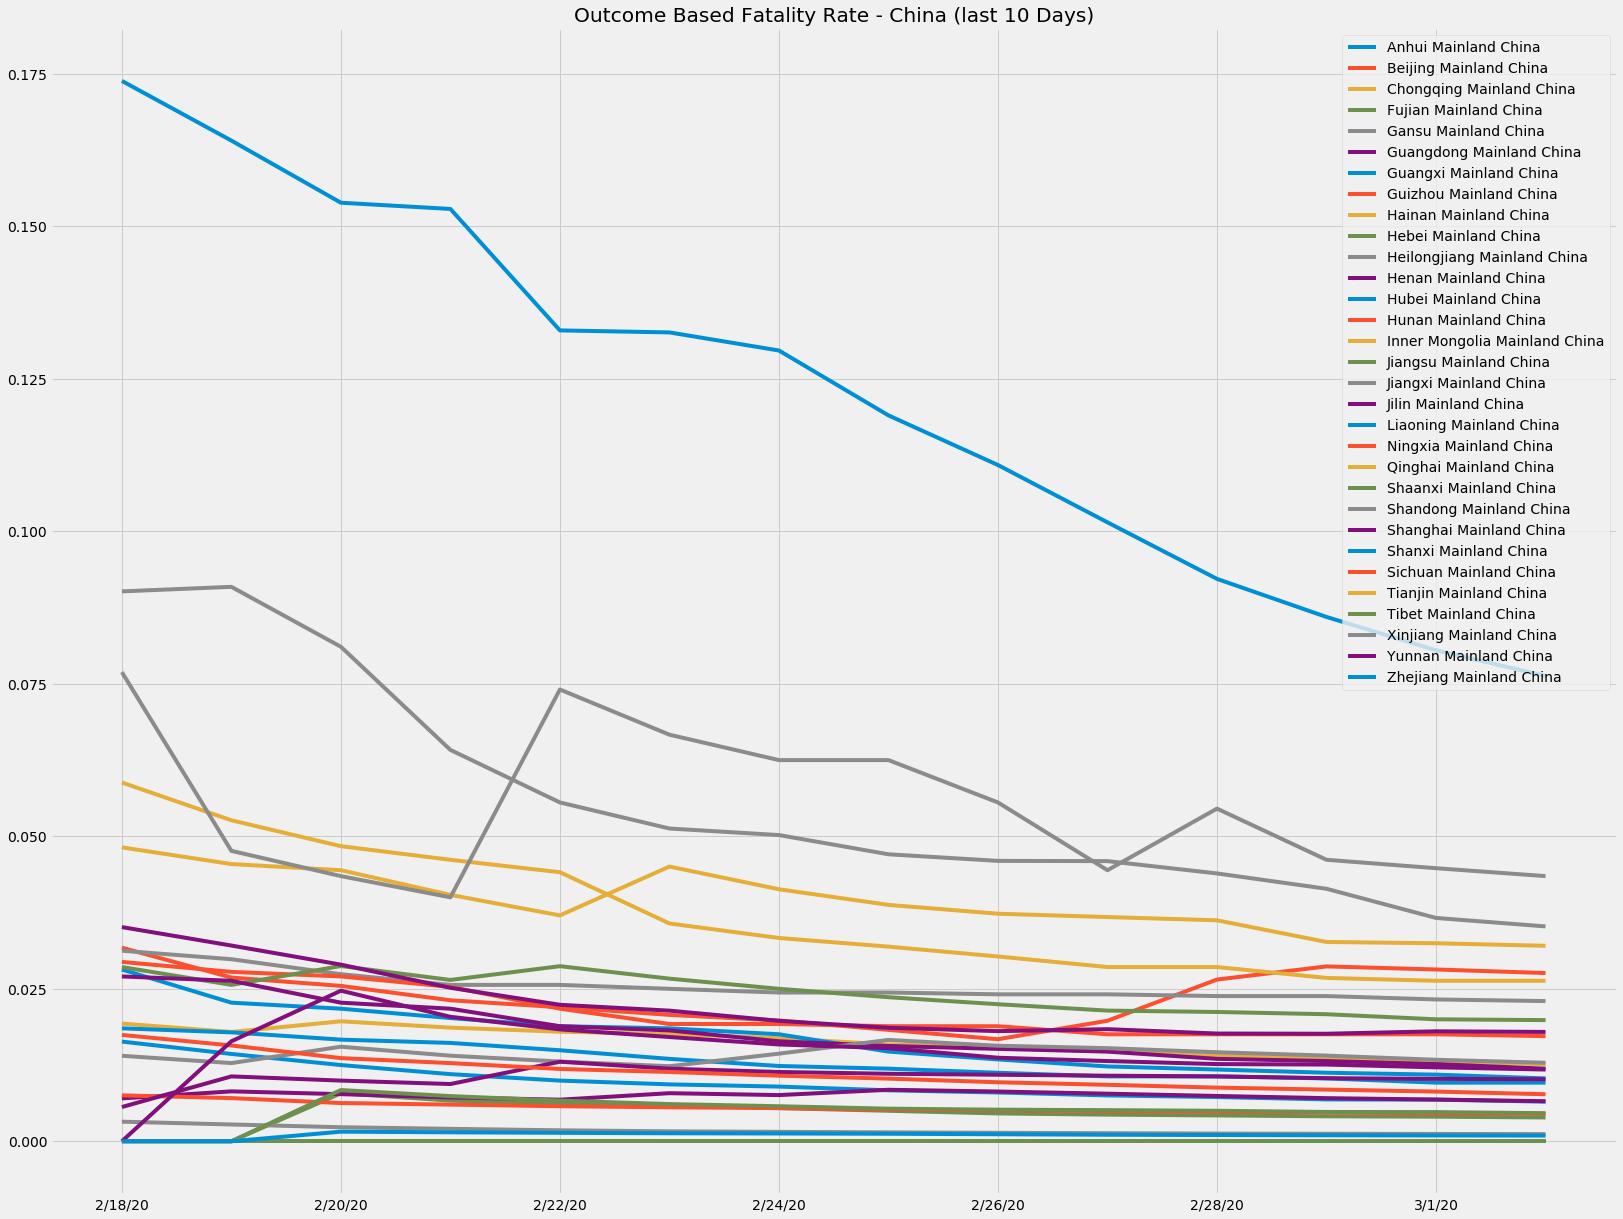

In [18]:
#China 
loc='China'
location = cfr.filter(regex=loc).tail(14)
rcParams['figure.figsize'] = 25,20
location.plot(title='Outcome Based Fatality Rate - China (last 10 Days)')
plt.legend()
plt.show()

Reference Rates: https://en.wikipedia.org/wiki/List_of_human_disease_case_fatality_rates